# Exploratory Data Analysis
spiegare quali siano gli obbiettivi per i quali stiamo preparando i dataset



## Import Packages
* Il pacchetto **numpy** serve a lavorare con valori e array numerici. Performa efficienti conti matematici e statistici.
* Il pacchetto **pandas** serve a manipolare, pulire e gestire dati strutturati attraverso strutture come i DataFrame.
* Il pacchetto **geopandas** è un'estensione del pacchetto *pandas* e serve per gestire dati geospaziali e visualizzarli in mappe.
* Il pacchetto **shapely** serve in collaborazione con geopandas per lavorare sulla geometria dei geodataframes.
* Il pacchetto **json** serve per caricare file con estensione `.json` 
* Il pacchetto **matplotlib** viene utilizzato per eseguire plot di grafici e lavorare su di essi.


In [2]:
import numpy as np

import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon
import json

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

## Importa Data

Il primo DataFrame contiene i dati sui consumi delle linee elettriche di tutto il Trentino.  
Per ogni linea elettrica viene fornito il dato di consumo ogni 10 minuti per l'intero mese.  
I dati sono per il mese di Novembre 2013 (il processo verrà ripetuto per il mese di Dicembre 2013).


Il secondo DataFrame contiene i dati riguardanti le ubicazioni e linee elettriche presenti in ogni zona del Trentino.  
Per ogni zona del Trentino (identificata da *SQUAREID*) vengono associate le linee elettriche da lì passanti (*LINESET*) e per ogni combinazione di zona e linea elettrica viene associato il numero di ubicazioni presenti (*NR_UBI*)



In [3]:
file_path_proc = "./data/processed/"
file_path_raw = "./data/data_trentino/raw/"
set_df = pd.read_csv(file_path_proc + "SET-nov-2013.csv")
lin_df = pd.read_csv(file_path_proc + "line.csv")
set_df[:5]

,LINESET,DATE,POWER
0,DG1000420,01/11/2013 00:00,37.439999
1,DG1000420,01/11/2013 00:10,37.439999
2,DG1000420,01/11/2013 00:20,36.000000
3,DG1000420,01/11/2013 00:30,35.279999
4,DG1000420,01/11/2013 00:40,35.279999


## Trasformazione colonna *DATE*
Trasformiamo la colonna *DATE* in tre colonne separate che indicano il giorno (*DAY*), i minuti (*MIN*) e il giorno della settimana (*WEEK_DAY*).

In [4]:
set_df["DATE"] = pd.to_datetime(set_df["DATE"], format="%d/%m/%Y %H:%M", dayfirst=True)
set_df["DAY"] = pd.to_datetime(set_df["DATE"]).dt.day
set_df["MINUTE"] = pd.to_datetime(set_df["DATE"]).dt.hour * 60 + pd.to_datetime(set_df["DATE"]).dt.minute
set_df["WEEK_DAY"] = pd.to_datetime(set_df["DATE"]).dt.day_of_week
del set_df["DATE"]
set_df[:5]

,LINESET,POWER,DAY,MINUTE,WEEK_DAY
0,DG1000420,37.439999,1,0,4
1,DG1000420,37.439999,1,10,4
2,DG1000420,36.000000,1,20,4
3,DG1000420,35.279999,1,30,4
4,DG1000420,35.279999,1,40,4


## Trasformazione corrente in potenza media
Trasformiamo la corrente erogata, in potenza media misurata in KWh.  
Alle ubicazioni civili viene associata una tensione trifase: 240V (RMS).  
Dunque: KWh = kV * I * 1h = 240V/1000 * I * 3600s = 240kV*3.6s * I = 864 KV*s * I  
Definisco quindi la costante di conversione `conv_to_KWh` := 864 KV*s e converto la colonna *POWER* in KWh.


In [5]:
conv_to_KWh = 240/1000*3600
set_df["POWER"] *= conv_to_KWh
set_df[:5]

,LINESET,POWER,DAY,MINUTE,WEEK_DAY
0,DG1000420,32348.159136,1,0,4
1,DG1000420,32348.159136,1,10,4
2,DG1000420,31104.000000,1,20,4
3,DG1000420,30481.919136,1,30,4
4,DG1000420,30481.919136,1,40,4


## Consumo mensile per zona
Quello che vogliamo vedere come prima cosa è qual'è il consumo medio mensile per ogni linea e per ogni zona.  

Quello che faremo sarà: 
* creare un dataframe ** unendo `set_df` e `lin_df` in modo da associare anche ad ogni zona la potenza
    * creiamo dei dataframe temporanei dove associamo 
* creare un dataframe ** con i valori di potenza mediati su tutto il mese
* 


In [6]:
# eseguiamo la media giornaliera della potenza 
mean_df = set_df.groupby("LINESET")["POWER"].sum()/set_df["DAY"].iloc[-1]

# uniamo il dataframe mediato con lin_df preservando le colonne LINESET, POWER, SQUAREID e NR_UBI
mean_df = pd.merge(mean_df,lin_df, on="LINESET", how="right")

# aggiungiamo colonna con il numero totale di ubicazioni per squareid
mean_df["TOT_UBI"] = lin_df.groupby("SQUAREID")["NR_UBI"].transform("sum")

# eseguiamo la media pesata della potenza sul numero di ubicazioni
mean_df["W_POWER"] = mean_df["POWER"] * mean_df["NR_UBI"] / mean_df["TOT_UBI"]
mean_df[18:25]

,LINESET,POWER,SQUAREID,NR_UBI,TOT_UBI,W_POWER
18,DG1031221,5.505828e+06,742,32,32,5.505828e+06
19,DG1003117,7.862083e+06,743,10,84,9.359623e+05
20,DG1031221,5.505828e+06,743,74,84,4.850373e+06
21,DG1003117,7.862083e+06,752,5,5,7.862083e+06
22,DG1031220,3.962304e+06,854,20,20,3.962304e+06
23,DG1031221,5.505828e+06,857,8,8,5.505828e+06
24,DG1031221,5.505828e+06,858,80,80,5.505828e+06


In [7]:
# creiamo il geodataframe di mean_df raggruppando per square id e sommando i vari contributi pesati di corrente
mean_gdf = gp.GeoDataFrame(mean_df.groupby("SQUAREID")["W_POWER"].sum())
mean_gdf[18:25]

,W_POWER
SQUAREID,
742,5.505828e+06
743,5.786335e+06
752,7.862083e+06
854,3.962304e+06
857,5.505828e+06
858,5.505828e+06
859,5.505828e+06


Importiamo i dati riguardanti le posizioni dei quadratini sulla griglia del trentino

In [8]:
tn_grid_gpd = gp.read_file(file_path_raw + "trentino-grid.geojson")
tn_grid_gpd[:5]

,cellId,geometry
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179..."
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157..."
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136..."
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.691, ..."
4,155,"POLYGON ((10.91493 45.691, 10.92777 45.69079, ..."


Uniamo i geodataframe `tn_grid_gpd` e `mean_gdf`

In [9]:
grid_mean_gpd = pd.merge(tn_grid_gpd,mean_gdf,left_on="cellId",right_on="SQUAREID").rename(columns={"cellId":"SQUAREID"})

# controlliamo anche che non siano presenti dei Not a Number
print(grid_mean_gpd.isna().sum())
grid_mean_gpd[3:8]

SQUAREID    0
geometry    0
W_POWER     0
dtype: int64


,SQUAREID,geometry,W_POWER
3,276,"POLYGON ((10.96659 45.69913, 10.97943 45.6989,...",7.862083e+06
4,277,"POLYGON ((10.97943 45.6989, 10.99226 45.69868,...",7.862083e+06
5,389,"POLYGON ((10.91554 45.70899, 10.92838 45.70878...",5.505828e+06
6,390,"POLYGON ((10.92838 45.70878, 10.94122 45.70856...",5.505828e+06
7,393,"POLYGON ((10.9669 45.70812, 10.97974 45.7079, ...",7.862083e+06


Facciamo un primo plot per capire se procede tutto come previsto

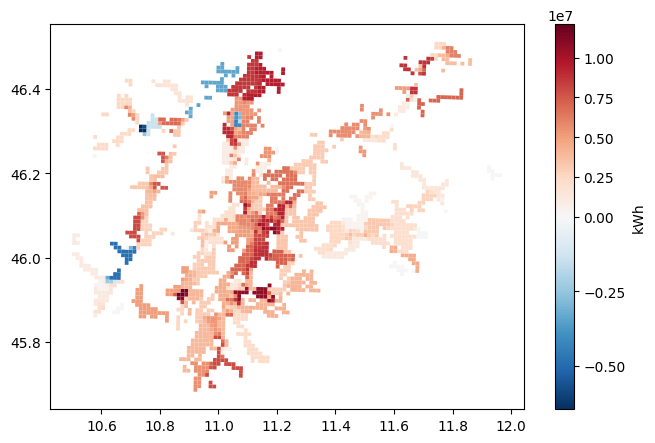

In [10]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(8, 5))

# create the colour shade
norm = TwoSlopeNorm(vmin=grid_mean_gpd['W_POWER'].min(), 
                    vcenter=0, 
                    vmax=grid_mean_gpd['W_POWER'].max())

# plot the map
grid_mean_gpd.plot(column='W_POWER', ax=ax, legend=True, legend_kwds={'label': "kWh", 'orientation': "vertical"},
                   cmap='RdBu_r', norm=norm)
plt.show()

Si nota subito che sono presenti della zone in cui il consumo medio giornaliero assume valori negativi. Una prima ipotesi intuitiva per giustificare il fatto, potrebbe essere dovuta alla presenza di centrali elettriche; cercheremo di capire in seguito se si tratta di un errore di dati oppure di motivo vero.  
Notiamo inoltre che ci sono delle zone a consumi maggiori, vedremo successivamente esattamente quali sono queste zone.

Intanto continuiamo plottando anche la mappa del trentino e le regioni amministrative:  
Per prima cosa importiamo i dati delle regioni amministrative e creiamo un geodataframe

In [12]:
# carichiamo il file using pandas e decifriamo il formato json con json_normalise()
# adm_reg_df = pd.read_json(file_path_raw + "administrative_regions_Trentino.json")
# items_df = pd.json_normalize(adm_reg_df["items"])
# items_df['geometry.coordinates'][3]
# # Extract geometry and convert to shapely Polygon objects
# items_df['geometry'] = items_df['geometry.coordinates'].apply(lambda x: Polygon(x[0]) if x is not None else None)

with open(file_path_raw + "administrative_regions_Trentino.json") as f:
    data = json.load(f)
    del f

items_df = data['items'] #pd.json_normalize(data['items'])

geometry = []

for item in items_df:
    if item['geometry']['type'] == 'Polygon':
        coordinates = item['geometry']['coordinates'][0]  # The first element contains the polygon coordinates
        polygon = Polygon(coordinates)  # Create a shapely Polygon object
        geometry.append(polygon)
    
geometry



# adm_reg_gdf = gp.GeoDataFrame(items_df,geometry='geometry.coordinates')
# adm_reg_gdf
del(data,item,items_df,)

ValueError: could not convert string to float: '.'

Ora plotto 

---

## Variazioni orarie e giornaliere dei consumi
Quello che andiamo ad analizzare ora sarà di vedere quali sono le zone a più alta variazione dei consumi durante l'arco della giornata e del mese.

Come prima cosa torniamo a lavorare sul dataframe `set_df` e creiamo due nuovi dataframes contenenti le variazioni orarie e giornaliere

In [23]:
var_ora_df = set_df

# creiamo la colonna ora
var_ora_df["HOUR"] = var_ora_df["MINUTE"] // 60

# eseguiamo la somma sui 60 minuti di ogni ora ed eseguiamo la differenza tra le varie righe
var_ora_df = var_ora_df.groupby(['LINESET', 'DAY', 'WEEK_DAY', 'HOUR'])['POWER'].sum().reset_index()
var_ora_df['VAR_POW'] = var_ora_df.groupby('LINESET')['POWER'].diff()
var_ora_df["VAR_POW"] = abs(var_ora_df["VAR_POW"])

# togliamo i not a number e riordiniamo le colonne
var_ora_df = var_ora_df.dropna(subset=['VAR_POW'])
var_ora_df = var_ora_df[['LINESET', 'VAR_POW', 'HOUR', 'DAY', 'WEEK_DAY']]

var_ora_df[:5]

,LINESET,VAR_POW,HOUR,DAY,WEEK_DAY
1,DG1000420,11197.442592,1,1,4
2,DG1000420,9797.760000,2,1,4
3,DG1000420,466.558272,3,1,4
4,DG1000420,3265.918272,4,1,4
5,DG1000420,1555.200864,5,1,4


In [33]:
var_day_df = set_df

# eseguiamo la somma della potenza sulle 24 ore di ogni giorno ed eseguiamo la differenza tra le varie righe
var_day_df = var_day_df.groupby(['LINESET', 'DAY', 'WEEK_DAY'])['POWER'].sum().reset_index()
var_day_df['VAR_POW'] = var_day_df.groupby('LINESET')['POWER'].diff()
var_day_df["VAR_POW"] = abs(var_day_df["VAR_POW"])

# togliamo i not a number e riordiniamo le colonne
var_day_df = var_day_df.dropna(subset=['VAR_POW'])
var_day_df = var_day_df[['LINESET', 'VAR_POW', 'DAY', 'WEEK_DAY']]

var_day_df[:5]

,LINESET,VAR_POW,DAY,WEEK_DAY
1,DG1000420,6.143040e+04,2,5
2,DG1000420,2.706051e+04,3,6
3,DG1000420,3.810706e+06,4,0
4,DG1000420,5.200589e+05,5,1
5,DG1000420,1.923783e+05,6,2


ciao

---

Divido il data frame *lin_df* in modo da poter contare il numero di ubicazioni presenti per ogni linea elettrica *LINESET* e contare il numero di ubicazioni presenti per ogni casella *SQUAREID*.

Per prima cosa creo un DataFrame temporaneo dove ad ogni linea *LINESET* associo il numero di ubicazioni passanti per essa:

In [223]:
temp_df_line = lin_df.groupby("LINESET")["NR_UBI"].sum().reset_index()
temp_df_line = temp_df_line.rename(columns={"NR_UBI": "UBI_X_LINE"})
temp_df_line[:5]

,LINESET,UBI_X_LINE
0,DG1000011,6
1,DG1000023,62
2,DG1000420,2133
3,DG1000421,1424
4,DG1000422,3423


Poi creo un DataFrame temporaneo dove ad ogni casella *SQUAREID* associo il numero di ubicazioni presenti:

In [224]:
temp_df_square = lin_df.groupby("SQUAREID")["NR_UBI"].sum().reset_index()
temp_df_square = temp_df_square.rename(columns={"NR_UBI": "UBI_X_SQUARE"})
temp_df_square[:5]

,SQUAREID,UBI_X_SQUARE
0,155,4
1,272,72
2,273,21
3,276,34
4,277,3


Dopo aver separato *lin_df* nei due data frame temporanei, li riunisco al data frame *lin_df* e a sua volta li unisco in un data frame finale insieme a *set_df* organizzandoli sotto *LINESET*.

In [225]:
final_df1=pd.merge(lin_df,temp_df_line,on="LINESET")
final_df1[:5]

,SQUAREID,LINESET,NR_UBI,UBI_X_LINE
0,155,DG1031221,4,1380
1,272,DG1031221,72,1380
2,273,DG1031221,21,1380
3,389,DG1031221,65,1380
4,390,DG1031221,8,1380


In [226]:

final_df2=pd.merge(final_df1,temp_df_square,on="SQUAREID")
final_df2[:5]

,SQUAREID,LINESET,NR_UBI,UBI_X_LINE,UBI_X_SQUARE
0,155,DG1031221,4,1380,4
1,272,DG1031221,72,1380,72
2,273,DG1031221,21,1380,21
3,389,DG1031221,65,1380,65
4,390,DG1031221,8,1380,8


In [227]:
final_df = pd.merge(final_df2,set_df, on = "LINESET")
final_df#[:5]

,SQUAREID,LINESET,NR_UBI,UBI_X_LINE,UBI_X_SQUARE,POWER,DAY,MINUTE,WEEK_DAY
0,155,DG1031221,4,1380,4,30274.560864,1,0,4
1,155,DG1031221,4,1380,4,25920.000000,1,10,4
2,155,DG1031221,4,1380,4,27993.598272,1,20,4
3,155,DG1031221,4,1380,4,26645.760000,1,30,4
4,155,DG1031221,4,1380,4,26438.398272,1,40,4
...,...,...,...,...,...,...,...,...,...
10928875,10984,DG1013504,2,74,2,138434.405184,30,1390,5
10928876,10984,DG1013504,2,74,2,139708.797408,30,1400,5
10928877,10984,DG1013504,2,74,2,137894.405184,30,1410,5
10928878,10984,DG1013504,2,74,2,139622.405184,30,1420,5
